### Imports

In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, YearLocator
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError, R2Score
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Dropout, Conv1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize
import seaborn as sns
import tensorflow as tf

In [266]:
%run UtilsNew.ipynb

### Load and filter data

In [286]:
raw_anual_df = pd.read_csv("data/minas_gerais_bh.csv", sep=";")
anual_df = pre_processing(raw_anual_df)

anual_df["hora"] = anual_df["data_hora"].dt.hour
anual_df = filter_between(anual_df, "hora", 7, 18)

### Data segmentation

In [287]:
train_size = int(0.7 * (round(len(anual_df)/10)*10))

train_df = anual_df.iloc[0:train_size]
test_df = anual_df.iloc[train_size:]

WINDOW_SIZE = 11

In [269]:
# train_df = anual_df.iloc[0:2155]
# test_df = anual_df.iloc[2155:]

# WINDOW_SIZE = 11

### Create input and output

In [351]:
def data_to_input_and_output(data):
    input_data = []
    output_data = []
    for index in range(0, len(data) - WINDOW_SIZE):
        input_sample = data['radiacao'][index:index + WINDOW_SIZE]
        output_sample = data['radiacao'][index + WINDOW_SIZE]
     
        input_data.append(input_sample)
        output_data.append(output_sample)

    # return normalize(np.array(input_data)), normalize([np.array(output_data)])[0]
    return np.array(input_data)/1000, np.array(output_data)/1000
    # return np.array(input_data), np.array(output_data)
    # return normalize_leo(np.array(input_data)), normalize_leo([np.array(output_data)])[0]

In [352]:
train_input, train_output = data_to_input_and_output(train_df)
test_input, test_output = data_to_input_and_output(test_df)

In [291]:
# train_input
# print(95.9/1000)
# print(441.2/1000)

### Training model

In [353]:
checkpoint_filepath = '/tmp/lstm/lstm_solar_model.h5'

def normalize_leo(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

def train_solar_lstm(X, y, epochs=100, learning_rate=0.001):
    model = Sequential()
    model.add(InputLayer(input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))  # saída contínua (radiação)

    check_point = ModelCheckpoint(filepath=checkpoint_filepath, 
                                  save_best_only=True, 
                                  monitor='loss')

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[
            MeanSquaredError(), 
            RootMeanSquaredError(),
            MeanAbsoluteError()
        ]
    )

    model.fit(X, y, epochs=epochs, callbacks=[check_point], verbose=1)

    return model

In [354]:
model = train_solar_lstm(train_input, train_output)

Epoch 1/100
96/96 [==============================] - 4s 11ms/step - loss: 0.9089 - mean_squared_error: 0.9071 - root_mean_squared_error: 0.9534 - mean_absolute_error: 0.7823
Epoch 2/100
96/96 [==============================] - 1s 12ms/step - loss: 0.1752 - mean_squared_error: 0.1753 - root_mean_squared_error: 0.4185 - mean_absolute_error: 0.3092
Epoch 3/100
96/96 [==============================] - 1s 11ms/step - loss: 0.1504 - mean_squared_error: 0.1504 - root_mean_squared_error: 0.3878 - mean_absolute_error: 0.2693
Epoch 4/100
96/96 [==============================] - 1s 8ms/step - loss: 0.1433 - mean_squared_error: 0.1430 - root_mean_squared_error: 0.3785 - mean_absolute_error: 0.2578
Epoch 5/100
96/96 [==============================] - 1s 8ms/step - loss: 0.1402 - mean_squared_error: 0.1403 - root_mean_squared_error: 0.3745 - mean_absolute_error: 0.2528
Epoch 6/100
96/96 [==============================] - 1s 6ms/step - loss: 0.1398 - mean_squared_error: 0.1397 - root_mean_squared_err

### Predicting

In [294]:
model = load_model(checkpoint_filepath)

In [301]:
train_pred = model.predict(train_input)
test_pred = model.predict(test_input)

41/41 [==============================] - 0s 5ms/step


In [317]:
def plot_results(df_orig, pred, real):
    set_plot_size(12, 6)
    
    period = df_orig[0:len(df_orig) - WINDOW_SIZE]['data']
    pred = pred.reshape(pred.shape[0])
    
    df_pred = pd.DataFrame(data=pred, index=period, columns=["predicted"])
    df_real = pd.DataFrame(data=real, index=period, columns=["real"])
    
    sns.lineplot(df_pred, palette=["red"], ci=None)
    sns.lineplot(df_real, palette=["blue"], ci=None)

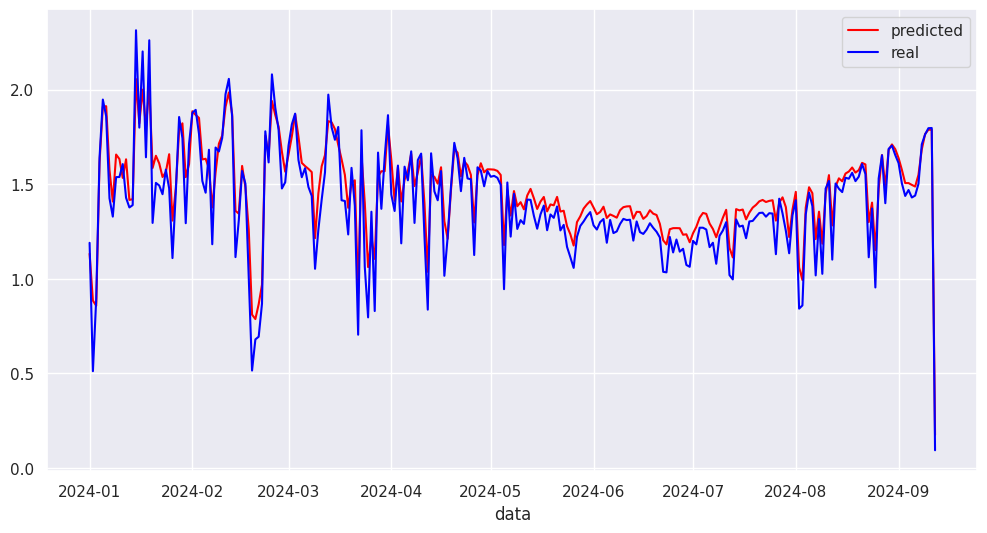

In [318]:
plot_results(train_df, train_pred, train_output)

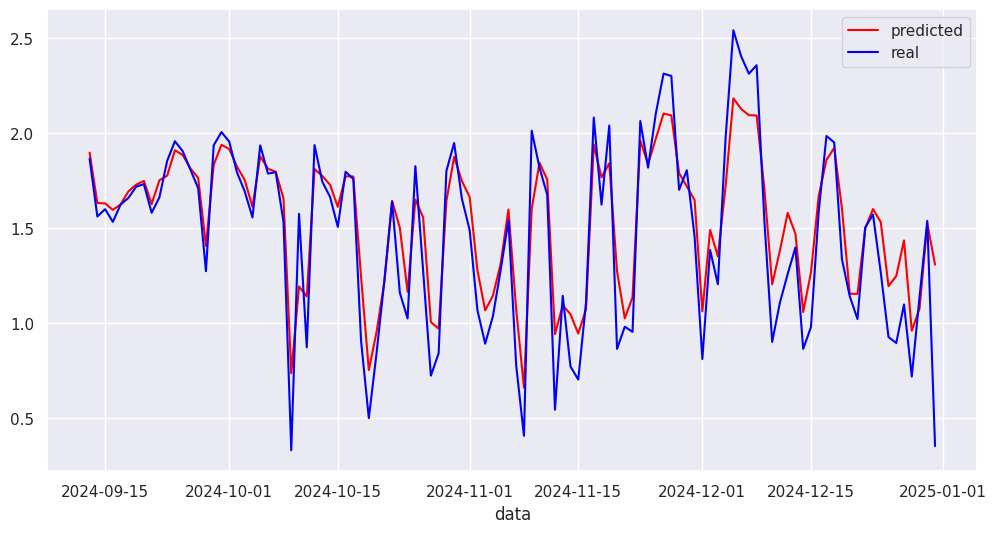

In [319]:
plot_results(test_df, test_pred, test_output)

In [380]:
metrics = model.get_metrics_result()

for i in metrics.keys():
    print(i + ": " + str(metrics[i]._summarize_value()))

loss: 0.115266435
mean_squared_error: 0.115520693
root_mean_squared_error: 0.3395091
mean_absolute_error: 0.217696771


In [381]:
# set_plot_size(12, 8)

# _input = np.linspace(0, 10, num=30)

# _output = _input**2

# df_deriv =pd.DataFrame({'x':_input, 'y':_output})

# sns.lineplot(df_deriv, x="x", y="y")

### Test with a XOR NN

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Dados de entrada (4 combinações do XOR)
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

# Saída esperada
y = np.array([[0], [1], [1], [0]])

# Construção da rede
model = Sequential()
model.add(Dense(2, input_dim=2, activation='tanh'))  # camada oculta com 2 neurônios
model.add(Dense(1, activation='sigmoid'))            # camada de saída

# Compilar o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinar
model.fit(X, y, epochs=1000, verbose=0)

# Avaliação
print("\nPrevisões da rede:")
print(model.predict(X).round())


Previsões da rede:
1/1 [==============================] - 0s 245ms/step
[[0.]
 [1.]
 [1.]
 [1.]]


### Simple NN test

In [130]:
dosages_input = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

weitghs_input = np.array([-34.4, -2.52])
weitghs_output = np.array([-1.3, 2.28])
bias = np.array([2.14, 1.29])

def softplus_np(x): 
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

neurons = []

for i in _input:
    partial_result = (weitghs_input*i) + bias
    result = softplus_np(partial_result)
    neurons.append(result)

neurons_output = (neurons*weitghs_output) - 0.58

print(neurons_output)

[[-3.50660238  2.91560146]
 [-0.89331099  2.47789732]
 [-0.59131089  2.06813341]
 [-0.58036421  1.6894574 ]
 [-0.58001168  1.34444521]
 [-0.58000037  1.03483206]
 [-0.58000001  0.76131276]
 [-0.58        0.52345762]
 [-0.58        0.31976472]
 [-0.58        0.1478356 ]
 [-0.58        0.00463266]]


In [106]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  
    return e_x / e_x.sum(axis=0)

In [ ]:
def plot():
    # Separate x and y coordinates
    x_coords, y_coords = zip(*neurons)
    
    # Create the plot
    plt.plot(x_coords, y_coords)
    
    # Add labels and title
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Plot of X and Y Coordinates")
    
    # Display the plot
    plt.show()